## Hamiltonianの定義

In [18]:
import itertools
import numpy as np
import scipy 
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import PauliEvolutionGate, PauliGate
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.synthesis import SuzukiTrotter
from qiskit.visualization import plot_histogram
import seaborn as sns

def tuple_to_bitstring(tup, Norb, rev=True):
    bitint = 0
    for i in tup:
        bitint += 2**i
    if rev:
        bitstring = "|"+format(bitint, f'0{Norb}b')[::-1]+">"
    else:
        bitstring = "|"+format(bitint, f'0{Norb}b')+">"        
    return bitstring

def cG1(circ, c_qubit, i, j, theta):
    theta_4 = theta / 4 
    circ.cx(i,j)
    circ.ry(theta_4, i)
    circ.cx(j,i)
    circ.ry(-theta_4, i)
    circ.cx(c_qubit, i)
    circ.ry(theta_4, i)
    circ.cx(j,i)
    circ.ry(-theta_4, i)
    circ.cx(c_qubit, i)
    circ.cx(i,j)

def cG1_gate(theta):
    circ = QuantumCircuit(2)
    G(circ, 0, 1, theta)
    circ.name = "cG1"   
    circ = circ.to_gate()
    circ = circ.control(1) 
    return circ

def G(circ, i, j, theta):
    theta_2 = theta / 2 
    circ.cx(i,j)
    circ.ry(theta_2, i)
    circ.cx(j,i)
    circ.ry(-theta_2, i)
    circ.cx(j,i)
    circ.cx(i,j)  

def G_gate(theta):
    circ = QuantumCircuit(2)
    G(circ, 0, 1, theta)
    circ.name = "G"    
    return circ.to_gate()

def get_idx_ancilla_in_string(n_qubit, ancilla, Qiskit_ordering):
    idx_ancilla = None
    if ancilla != None:
        if Qiskit_ordering:
            idx_ancilla = n_qubit-1 - ancilla
        else:
            idx_ancilla = ancilla
    return idx_ancilla

def expec_Zstring(res, idx_relevant, Qiskit_ordering=True, target_qubits=[], ancilla_qubit=None):
    exp_val = exp_val_p0 = exp_val_p1 = 0.0
    n_shot = sum(res.values())
    n_qubit = len(list(res.keys())[0])
    idx_ancilla = get_idx_ancilla_in_string(n_qubit, ancilla_qubit, Qiskit_ordering)
    for bitstr, count in res.items():
        if ancilla_qubit != None and target_qubits != []:
            bitstr_target = ''.join([bitstr[k] for k in range(n_qubit) if k != idx_ancilla])
        else:
            bitstr_target = bitstr
        tmp = 1.0
        for idx in idx_relevant:
            if Qiskit_ordering:
                idx = -1 - idx
            bit = int(bitstr_target[idx])            
            tmp *= (1 - 2 * bit)
        exp_val += tmp * count
        
        if ancilla_qubit != None:
            if int(bitstr[idx_ancilla]) == 0:
                exp_val_p0 += tmp * count
            else:
                exp_val_p1 += tmp * count
    exp_val /= n_shot; exp_val_p0 /= n_shot; exp_val_p1 /= n_shot
    return exp_val, exp_val_p0, exp_val_p1
# ==== パラメータ設定 ====
num_orbitals = 6
num_particles = 3
delta = 1.0   # 1体項の等間隔エネルギー
v = 0.3       # 2体相互作用（ペア＋単粒子遷移含む）
w3 = 0.2      # 3体相互作用

# ==== 基底生成 ====
def generate_basis(num_orbitals, num_particles):
    basis = []
    for bits in itertools.combinations(range(num_orbitals), num_particles):
        occ = np.zeros(num_orbitals, dtype=int)
        occ[list(bits)] = 1
        basis.append(tuple(occ))
    return basis

basis = generate_basis(num_orbitals, num_particles)
dim = len(basis)

# ==== 生成消滅演算の定義 ====
def apply_annihilate(state, i):
    state = list(state)
    if state[i] == 0:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 0
    return tuple(state), sign

def apply_create(state, i):
    state = list(state)
    if state[i] == 1:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 1
    return tuple(state), sign

def apply_cdag_c(state, i, j):
    """c_i† c_j"""
    s1, sign1 = apply_annihilate(state, j)
    if s1 is None:
        return None, 0
    s2, sign2 = apply_create(s1, i)
    if s2 is None:
        return None, 0
    return s2, sign1 * sign2

# ==== 1体ハミルトニアン ====
H1 = np.zeros((dim, dim))
for p, s in enumerate(basis):
    for i, occ in enumerate(s):
        if occ == 1:
            energy = delta * (i // 2)  # 各2縮退レベルごとに等間隔
            H1[p, p] += energy

# ==== 2体ハミルトニアン（改訂版）====
pairs = [(0, 1), (2, 3), (4, 5)]
H2 = np.zeros((dim, dim))

def find_pair_and_single(state):
    """3粒子状態から (pair_index, single_orbital) を特定"""
    for p_idx, (a, b) in enumerate(pairs):
        if state[a] == 1 and state[b] == 1:
            s = [i for i in range(len(state)) if state[i] == 1 and i not in (a, b)][0]
            return p_idx, s
    return None, None

# すべてのペア・単粒子遷移を許す
for i, bra in enumerate(basis):
    p_bra, s_bra = find_pair_and_single(bra)
    if p_bra is None:
        continue  # ペアがない状態は作用しない

    for j, ket in enumerate(basis):
        p_ket, s_ket = find_pair_and_single(ket)
        if p_ket is None:
            continue

        # ペアと単粒子の両方が遷移できる
        # 全結合を許して同一強度v
        H2[i, j] += v



# ==== 3体ハミルトニアン（変更なし）====
triplets = [(0,1,2), (1,2,3), (2,3,4), (3,4,5)]
H3 = np.zeros((dim, dim))

for T1 in triplets:
    for T2 in triplets:
        for i, s in enumerate(basis):
            if all(s[k] == 1 for k in T2):
                s_new = list(s)
                sign = 1
                # アニヒレート
                for k in reversed(T2):
                    s_new, sgn = apply_annihilate(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                # クリエイト
                for k in T1:
                    s_new, sgn = apply_create(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                s_new = tuple(s_new)
                if s_new in basis:
                    j = basis.index(s_new)
                    H3[i, j] += w3 * sign

# ==== 総ハミルトニアン ====
H = H1 + H2 + H3
H = (H + H.conj()) / 2  # Hermitian化

# ==== 結果表示 ====
np.set_printoptions(precision=4, suppress=True)
print("Hamiltonian matrix (dim={}):".format(dim))
print(H)

# ==== 固有値 ====
eigvals, eigvecs= np.linalg.eigh(H)
print("\nEigenvalues:")
print(np.round(eigvals, 4))
print("\nGS Eigenvector")
print(np.round(eigvecs[:, 0], 4))
Egs_exact = eigvals[0]


Hamiltonian matrix (dim=20):
[[1.5 0.3 0.3 0.3 0.3 0.  0.  0.  0.  0.3 0.5 0.  0.  0.  0.  0.3 0.5 0.3
  0.3 0.5]
 [0.3 1.3 0.3 0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.3 0.3 2.3 0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.3 0.3 0.3 2.3 0.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.3 0.3 0.3 0.3 2.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.3 0.3 0.3 0.3 0.3 0.  0.  0.  0.  4.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.5 0.3 0.3 0.3 0.3 0.  0.  0.  0.  0.3 2.5 0.  0.  0.  0.  0.3 0.5 0.3
  0.3 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

## HamiltonianをPauli Stringへ変換

量子コンピュータ上で演算や測定が可能となる最小の基底がPauli行列であるため、HamiltonianをPauli行列のテンソル積に移し替える必要がある。

In [19]:
import itertools
import numpy as np

# ==== 全基底（64次元） ====
all_basis = [tuple(int(x) for x in format(i, '06b')) for i in range(2**6)]

# ==== 3粒子空間の基底インデックスを求める ====
basis_index = [all_basis.index(b) for b in basis]

# ==== 20次元→64次元への埋め込み ====
H_full = np.zeros((64, 64), dtype=complex)
for i, bi in enumerate(basis_index):
    for j, bj in enumerate(basis_index):
        H_full[bi, bj] = H[i, j]

# ==== パウリ行列定義 ====
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
paulis = [I, X, Y, Z]
labels = ['I','X','Y','Z']

# ==== Pauli 展開 ====
coeffs = {}
for ops in itertools.product(range(4), repeat=6):
    P = paulis[ops[0]]
    for k in ops[1:]:
        P = np.kron(P, paulis[k])
    c = np.trace(P @ H_full) / 64
    if abs(c) > 1e-8:
        label = ''.join(labels[k] for k in ops)
        coeffs[label] = np.real_if_close(c)

# ==== 出力 ====
print(f"\nNonzero Pauli terms ({len(coeffs)} terms):")
for k, v in sorted(coeffs.items(), key=lambda x: -abs(x[1])):
    print(f"{k:10s} : {v:.6f}")



Nonzero Pauli terms (652 terms):
IIIIII     : 1.006250
ZZZZZZ     : -1.006250
IIZIIZ     : -0.218750
IZIIZI     : -0.218750
IZZIZZ     : 0.218750
ZIIZII     : -0.218750
ZIZZIZ     : 0.218750
ZZIZZI     : 0.218750
IIZIZI     : -0.212500
IZIIIZ     : -0.212500
ZIZZZI     : 0.212500
ZZIZIZ     : 0.212500
IZIZII     : -0.212500
ZIZIZZ     : 0.212500
IZZZIZ     : 0.212500
ZIIIZI     : -0.212500
IZZZZI     : 0.206250
ZIIIIZ     : -0.206250
IZIZZZ     : 0.206250
ZIZIII     : -0.206250
IIIZIZ     : -0.206250
ZZZIZI     : 0.206250
IZZIII     : -0.200000
ZIIZZZ     : 0.200000
IIIZZI     : -0.200000
ZZZIIZ     : 0.200000
IZZZZZ     : -0.193750
ZIIIII     : 0.193750
IIIIZI     : -0.187500
IZIIII     : 0.187500
ZIZZZZ     : -0.187500
ZZZZIZ     : 0.187500
IIIIIZ     : -0.181250
ZZZZZI     : 0.181250
IIZZII     : -0.168750
ZZIIZZ     : 0.168750
IIIIZZ     : -0.162500
ZZZZII     : 0.162500
IIZZZZ     : 0.162500
ZZIIII     : -0.162500
IIZIZZ     : 0.125000
ZZIZII     : -0.125000
IIIZZZ     : 0.125000

## 参照状態の作成

参照状態としてHartree-Fock状態とtripletを作った状態の線型結合を考える。

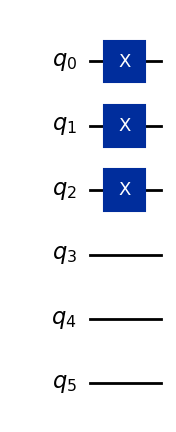

In [21]:
from qiskit.visualization import circuit_drawer


qc_prep = QuantumCircuit(num_orbitals)
qc_prep.x(0)
qc_prep.x(1)
qc_prep.x(2)
circuit_drawer(qc_prep, output="mpl")

norm: 1.0


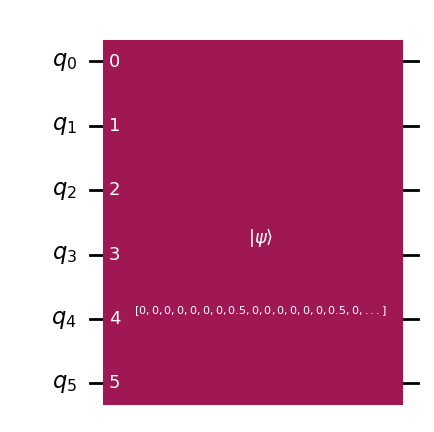

In [101]:
# 6量子ビット
qc_prep2 = QuantumCircuit(6)

# 4つの状態のインデックス（ビッグエンディアンで考える場合の例。Qiskitはリトルエンディアン表示に注意）
# ここでは Qiskit の状態ベクトルインデックスに合わせて、ビット文字列を右端が最下位（q0）と扱います。
# 状態: |000111>, |001110>, |011100>, |111000>
# これらの整数インデックス（b5 b4 b3 b2 b1 b0 を左→右）を計算すると: 7, 14, 28, 56
idx = [7, 14, 28, 56]

# 全64要素のゼロベクトルを作り、該当位置に振幅1/2を代入
state = np.zeros(2**6, dtype=complex)
amp = 1/2  # 規格化済み振幅
for i in idx:
    state[i] = amp

# sanity check: norm==1
print("norm:", np.linalg.norm(state))

# initialize を使って状態を準備
qc_prep2.initialize(state, qc_prep2.qubits)

from qiskit_aer import AerSimulator
backend = AerSimulator()

tqc = transpile(qc_prep2, backend=backend, optimization_level=3)
tqc.draw('mpl')

In [102]:
Uprep = qc_prep.to_gate()
Uprep.name = "$U_p$" 
Updag = Uprep.inverse()

In [23]:
qc_prep = QuantumCircuit(num_orbitals)
qc_prep.append(Uprep, range(num_orbitals))
state_vector = Statevector.from_instruction(qc_prep)
display(state_vector.draw("latex"))

# 逆演算U^{\dagger}_pを作用させて|0>に戻るかチェック
qc_prep.append(Updag, range(num_orbitals))
state_vector = Statevector.from_instruction(qc_prep)
display(state_vector.draw("latex"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [51]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

# ==== coeffs は前のコードで作成済みの辞書 ====
# 例: coeffs = {'IIIIII': 1.0, 'ZZIIII': 0.3, ...}

# Pauli文字列と係数をリストに変換
pauli_strings = list(coeffs.keys())
coeff_values  = np.array([coeffs[k] for k in pauli_strings], dtype=float)

# SparsePauliOp を作成
H = SparsePauliOp(pauli_strings, coeff_values)

print(H)

SparsePauliOp(['IIIIII', 'IIIIIZ', 'IIIIXX', 'IIIIYY', 'IIIIZI', 'IIIIZZ', 'IIIXIX', 'IIIXXI', 'IIIYIY', 'IIIYYI', 'IIIZII', 'IIIZIZ', 'IIIZZI', 'IIIZZZ', 'IIXIIX', 'IIXIXI', 'IIXIZX', 'IIXXII', 'IIXXXX', 'IIXXYY', 'IIXXZZ', 'IIXYXY', 'IIXYYX', 'IIXZIX', 'IIXZXZ', 'IIXZZX', 'IIYIIY', 'IIYIYI', 'IIYIZY', 'IIYXXY', 'IIYXYX', 'IIYYII', 'IIYYXX', 'IIYYYY', 'IIYYZZ', 'IIYZIY', 'IIYZYZ', 'IIYZZY', 'IIZIII', 'IIZIIZ', 'IIZIZI', 'IIZIZZ', 'IIZXXZ', 'IIZXZX', 'IIZYYZ', 'IIZYZY', 'IIZZII', 'IIZZIZ', 'IIZZXX', 'IIZZYY', 'IIZZZI', 'IIZZZZ', 'IXIIIX', 'IXIIXI', 'IXIIXZ', 'IXIXII', 'IXIXXX', 'IXIXYY', 'IXIXZZ', 'IXIYXY', 'IXIYYX', 'IXIZXI', 'IXIZXZ', 'IXIZZX', 'IXXIII', 'IXXIXX', 'IXXIYY', 'IXXIZZ', 'IXXXIX', 'IXXXXI', 'IXXYIY', 'IXXYYI', 'IXXZIZ', 'IXXZXX', 'IXXZYY', 'IXXZZI', 'IXYIXY', 'IXYIYX', 'IXYXIY', 'IXYXYI', 'IXYYIX', 'IXYYXI', 'IXYZXY', 'IXYZYX', 'IXZIXI', 'IXZIXZ', 'IXZIZX', 'IXZXIZ', 'IXZXZI', 'IXZZIX', 'IXZZXI', 'IXZZXZ', 'IYIIIY', 'IYIIYI', 'IYIIYZ', 'IYIXXY', 'IYIXYX', 'IYIYII', 'IYIY

Full HamiltonianでQKSを行うとPauli項が652となり、計算時間が大きくなった。iteration=1ですら1時間以上かかる。
Pauliの係数が0.02以下のものはとり除くことにした。Pauli項は154と大幅に削減される。

In [83]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

# --- 例：あなたのハミルトニアンを H とする ---
# H = SparsePauliOp([...], coeffs=[...])

# 絶対値が 0.01 以下の項を除外
mask = np.abs(H.coeffs) > 0.02
H_op = SparsePauliOp(H.paulis[mask], coeffs=H.coeffs[mask])

# 結果を確認
print(f"元の項数: {len(H.paulis)}")
print(f"削除後の項数: {len(H_op.paulis)}")
print("上位いくつかの項:")
print(H_op)

元の項数: 652
削除後の項数: 154
上位いくつかの項:
SparsePauliOp(['IIIIII', 'IIIIIZ', 'IIIIZI', 'IIIIZZ', 'IIIZIZ', 'IIIZZI', 'IIIZZZ', 'IIXIIX', 'IIXZZX', 'IIYIIY', 'IIYZZY', 'IIZIIZ', 'IIZIZI', 'IIZIZZ', 'IIZZII', 'IIZZIZ', 'IIZZZI', 'IIZZZZ', 'IXIIXI', 'IXIZXZ', 'IXXIXX', 'IXXIYY', 'IXYIXY', 'IXYIYX', 'IXZIXZ', 'IXZZXI', 'IYIIYI', 'IYIZYZ', 'IYXIXY', 'IYXIYX', 'IYYIXX', 'IYYIYY', 'IYZIYZ', 'IYZZYI', 'IZIIII', 'IZIIIZ', 'IZIIZI', 'IZIIZZ', 'IZIZII', 'IZIZZZ', 'IZXIZX', 'IZXZIX', 'IZYIZY', 'IZYZIY', 'IZZIII', 'IZZIZZ', 'IZZZII', 'IZZZIZ', 'IZZZZI', 'IZZZZZ', 'XIIXII', 'XIIXZZ', 'XIZXIZ', 'XIZXZI', 'XXIXXI', 'XXIYYI', 'XXXXXX', 'XXXXYY', 'XXYXXY', 'XXYXYX', 'XXYYYY', 'XXZXXZ', 'XXZYYZ', 'XYIXYI', 'XYIYXI', 'XYXXXY', 'XYXXYX', 'XYXYXX', 'XYYXYY', 'XYYYXY', 'XYYYYX', 'XYZXYZ', 'XYZYXZ', 'XZIXIZ', 'XZIXZI', 'XZZXII', 'XZZXZZ', 'YIIYII', 'YIIYZZ', 'YIZYIZ', 'YIZYZI', 'YXIXYI', 'YXIYXI', 'YXXXXY', 'YXXXYX', 'YXXYXX', 'YXYXYY', 'YXYYXY', 'YXYYYX', 'YXZXYZ', 'YXZYXZ', 'YYIXXI', 'YYIYYI', 'YYXXXX', 'YYXYXY', 'YY

Pauli項を削減したら、元のHamiltonianの固有値が変わるのではという不安があるので、固有値を確かめておく。

In [96]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp

# --- 例: あなたのハミルトニアンを H_full とする ---
# すでに SparsePauliOp 型になっている前提です
# H_full = SparsePauliOp([...], coeffs=[...])

# (1) 係数の絶対値が 0.01 以下のものを除去
#threshold = 0.01
#mask = np.abs(H_full.coeffs) > threshold
#H_op = SparsePauliOp(H_full.paulis[mask], coeffs=H_full.coeffs[mask])

print(f"元の項数: {len(H.paulis)} → {len(H_op.paulis)} に削減")

# (2) 行列に変換
H_matrix = H_op.to_matrix()

# (3) 固有値と固有ベクトルを計算
eigvals, eigvecs = np.linalg.eigh(H_matrix)

# (4) 結果を表示
#print("固有値:")
#print(np.round(eigvals, 6))
print(H_matrix)
# 最小固有値（基底エネルギー）を確認
E0 = np.min(eigvals)
print(f"\n基底エネルギー（最小固有値）: {E0:.6f}")

元の項数: 652 → 154 に削減
[[ 0.   +0.j  0.   +0.j  0.   +0.j ...  0.   +0.j  0.   +0.j -0.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.   +0.j ...  0.   +0.j  0.025+0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.05 +0.j ...  0.025+0.j  0.   +0.j  0.   +0.j]
 ...
 [ 0.   +0.j  0.   +0.j  0.025+0.j ... -0.05 +0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.025+0.j  0.   +0.j ...  0.   +0.j  0.   +0.j  0.   +0.j]
 [-0.   +0.j  0.   +0.j  0.   +0.j ...  0.   +0.j  0.   +0.j  0.   +0.j]]

基底エネルギー（最小固有値）: -0.055902


なぜか55個の固有値が生じる。後方の20個はFull Hamiltonianで与えられるexactな解から少しずれたものになっている。元々基底エネルギーは1.0641であったが1.1827となっている。

## 時間発展演算子の定義

In [86]:
trotter_steps = 1 
ancilla_qubits = [0]
target_qubits = list(range(1,num_orbitals+1))

t_i = 0.12
t_j = 0.56
Ui = PauliEvolutionGate(H_op, t_i, synthesis=SuzukiTrotter(order=1,reps=trotter_steps))
Uj = PauliEvolutionGate(H_op, t_j, synthesis=SuzukiTrotter(order=1,reps=trotter_steps))

circuit_Ui = QuantumCircuit(num_orbitals)
circuit_Ui.append(Ui, range(num_orbitals))
circuit_Ui.name = '$U(t_i)$'
gate_Ui = circuit_Ui.to_gate()

circuit_Uj = QuantumCircuit(num_orbitals)
circuit_Uj.append(Uj, range(num_orbitals))
circuit_Uj.name = '$U(t_j)$'
gate_Uj = circuit_Uj.to_gate()

# c-Ui: controlled U = exp(-iHt_i)
circuit_cUi = QuantumCircuit(num_orbitals)
circuit_cUi.append(Uprep, range(num_orbitals))
circuit_cUi.append(Ui, range(num_orbitals))
circuit_cUi.name = 'c-$U(t_i) U_p$'
gate_cUi = circuit_cUi.to_gate().control(1)

# C-Uj 
circuit_cUj = QuantumCircuit(num_orbitals)
circuit_cUj.append(Uprep, range(num_orbitals))
circuit_cUj.append(Uj, range(num_orbitals))
circuit_cUj.name = 'c-$U(t_j) U_p$'
gate_cUj = circuit_cUj.to_gate().control(1)

In [94]:
qc_psi_i = QuantumCircuit(num_orbitals)
qc_psi_i.append(Uprep, range(num_orbitals))
qc_psi_i.append(gate_Ui, range(num_orbitals))
psi_i = Statevector.from_instruction(qc_psi_i)

qc_psi_j = QuantumCircuit(num_orbitals)
qc_psi_j.append(Uprep, range(num_orbitals))
qc_psi_j.append(gate_Uj, range(num_orbitals))
psi_j = Statevector.from_instruction(qc_psi_j)

overlap = np.dot(psi_i.data.conj(), psi_j.data)
Re_overlap = np.real(overlap)
Im_overlap = np.imag(overlap)

print("psi_i"); display(psi_i.draw("latex"))
print("psi_j"); display(psi_j.draw("latex"))
print("<psi_i|psi_j>", overlap)
print("cos(t_i-t_j)", np.cos( np.sum(coeff_values) * (t_i-t_j) ), "sin(t_i-t_j)",  np.sin( np.sum(coeff_values) * (t_i-t_j) ) )

psi_i


/Users/ritsu/Desktop/QFF/qiskit_env/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/ritsu/Desktop/QFF/qiskit_env/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


<IPython.core.display.Latex object>

psi_j


<IPython.core.display.Latex object>

<psi_i|psi_j> (-0.6963526851077181-0.5836798756265987j)
cos(t_i-t_j) 0.9758974493306054 sin(t_i-t_j) -0.21822962308086946


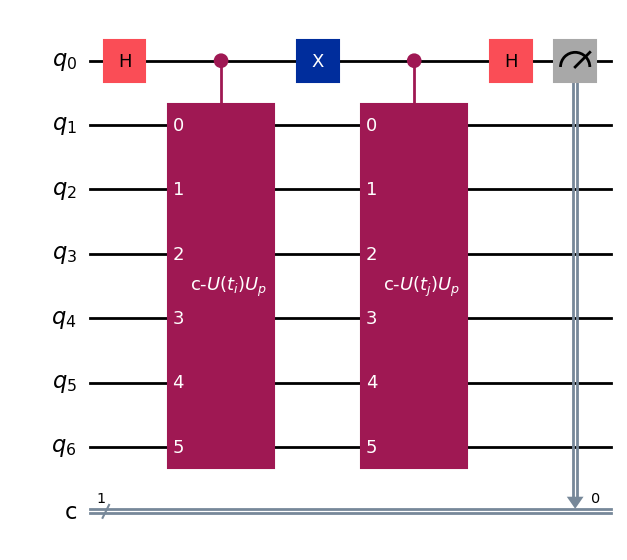

In [87]:
# circuit to measure Re <psi_i|psi_j>
qc_re = QuantumCircuit(1+num_orbitals,1)
qc_re.h(0)
qc_re.append(gate_cUi, ancilla_qubits + target_qubits)
qc_re.x(0)
qc_re.append(gate_cUj, ancilla_qubits+target_qubits)
qc_re.h(0)
qc_re.measure(0,0)
display(qc_re.draw('mpl'))
qc_re = qc_re.decompose()

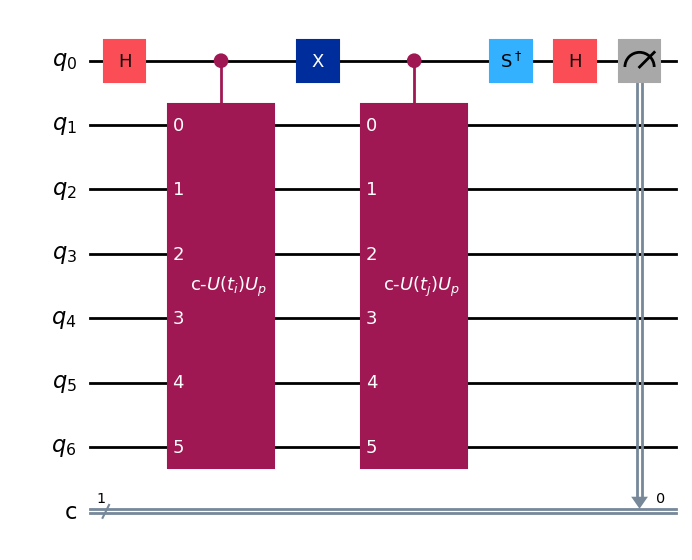

In [88]:
# circuit to measure Im <psi_i|psi_j>
qc_im = QuantumCircuit(1+num_orbitals,1)
qc_im.h(0)
qc_im.append(gate_cUi, ancilla_qubits + target_qubits)
qc_im.x(0)
qc_im.append(gate_cUj, ancilla_qubits+target_qubits)
qc_im.sdg(0)
qc_im.h(0)
qc_im.measure(0,0)
display(qc_im.draw('mpl'))
qc_im = qc_im.decompose()

In [89]:
from qiskit_aer.primitives import SamplerV2
sampler = SamplerV2()
num_shot = 10**5

job = sampler.run([qc_re, qc_im], shots=num_shot)
results  = job.result()

# Real part
prob = results[0].data.c.get_counts()
p0 = prob.get('0',0) / num_shot
p1 = prob.get('1',0) / num_shot
print(f"Estimated Re<psi_i|psi_j> = {p0 - p1:9.5f}  Exact: {Re_overlap:9.5f} Error: {np.abs(p0-p1-Re_overlap):6.2e}")

# Imaginary part
prob = results[1].data.c.get_counts()
p0 = prob.get('0',0) / num_shot
p1 = prob.get('1',0) / num_shot
print(f"Estimated Im<psi_i|psi_j> = {p0 - p1:9.5f}  Exact: {Im_overlap:9.5f} Error: {np.abs(p0-p1-Im_overlap):6.2e}")

Estimated Re<psi_i|psi_j> =  -0.65792  Exact:  -0.64551 Error: 1.24e-02
Estimated Im<psi_i|psi_j> =  -0.60816  Exact:  -0.58389 Error: 2.43e-02


XXIIIY


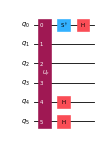

IYIYII


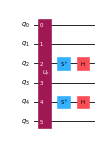

In [90]:
def additional_qc(qc_in, pauli_str, register_target, Qiskit_order=True):
    pauli_str = str(pauli_str)
    if Qiskit_order:
        pauli_str = pauli_str[::-1]

    for i in range(len(pauli_str)):
        if pauli_str[i] == "X":
            qc_in.h(register_target[i])
        elif pauli_str[i] == "Y":
            qc_in.sdg(register_target[i]); qc_in.h(register_target[i])
        elif pauli_str[i] == "Z" or pauli_str[i] == "I":
            pass
        else:
            raise ValueError("Invalid Pauli string: ", pauli_str)

def get_idx_to_measure(pauli_str, Qiskit_order=True):
    idxs = [ idx for idx, p in enumerate(pauli_str) if p != "I"]
    if Qiskit_order:
        idxs = [ len(pauli_str) - 1 - idx for idx in idxs]
    return idxs

hamil = ["XXIIIY", "IYIYII"]
for h in hamil:
    idx_relevant = get_idx_to_measure(h)
    print(h) # idx_relevant)
    qc = QuantumCircuit(num_orbitals)
    qc.append(Uprep, range(num_orbitals))
    additional_qc(qc, h, range(num_orbitals))    
    display(qc.draw('mpl', scale=0.3))

In [91]:
Hamil_coeffs = H_op.coeffs
Hamil_paulis = H_op.paulis

idxs_relevant = [ ]
qcs = [ ]
verbose = False
using_statevector = True
for h_term in list(H_op.paulis):
    h_term = h_term.to_label()
    idx_relevant = get_idx_to_measure(h_term)
    idxs_relevant.append(idx_relevant)
    qc = QuantumCircuit(num_orbitals)
    qc.append(Uprep, range(num_orbitals))
    additional_qc(qc, h_term, range(num_orbitals))
    if verbose:
        print(h_term, idx_relevant)
        display(qc.draw('mpl', scale=0.5))
    qc = qc.decompose().decompose()
    if not(using_statevector):
        qc.measure_all()
    qcs.append(qc)


if using_statevector:
    results = [ Statevector.from_instruction(qc).probabilities_dict() for qc in qcs]
else:
    job = sampler.run(qcs, shots=num_shot)
    results  = job.result()

Esum = 0.0
for idx in range(len(qcs)):
    h_term = H_op.paulis[idx]
    idx_relevant = idxs_relevant[idx]
    if using_statevector:
        res = results[idx]
    else:
        res = results[idx].data.meas.get_counts()

    expval, dummy, dummy_ = expec_Zstring(res, idx_relevant)
    print(h_term.to_label(), Hamil_coeffs[idx], expval)
    Esum += Hamil_coeffs[idx] * expval
print("Esum", Esum, "Egs_exact", Egs_exact)

IIIIII (1.00625+0j) 1.0
IIIIIZ (-0.18125000000000005+0j) -1.0
IIIIZI (-0.1875+0j) -1.0
IIIIZZ (-0.1625+0j) 1.0
IIIZIZ (-0.20624999999999996+0j) 1.0
IIIZZI (-0.19999999999999996+0j) 1.0
IIIZZZ (0.12499999999999997+0j) -1.0
IIXIIX (0.025+0j) 0.0
IIXZZX (0.025+0j) 0.0
IIYIIY (0.025+0j) 0.0
IIYZZY (0.025+0j) 0.0
IIZIIZ (-0.21875+0j) -1.0
IIZIZI (-0.21250000000000002+0j) -1.0
IIZIZZ (0.125+0j) 1.0
IIZZII (-0.16875+0j) -1.0
IIZZIZ (0.06875000000000002+0j) 1.0
IIZZZI (0.06250000000000001+0j) 1.0
IIZZZZ (0.16249999999999998+0j) -1.0
IXIIXI (0.025+0j) 0.0
IXIZXZ (-0.025+0j) 0.0
IXXIXX (0.025+0j) 0.0
IXXIYY (-0.025+0j) -1.3877787807814457e-17
IXYIXY (0.025+0j) 0.0
IXYIYX (0.025+0j) -1.3877787807814457e-17
IXZIXZ (-0.025+0j) 0.0
IXZZXI (0.025+0j) 0.0
IYIIYI (0.025+0j) 0.0
IYIZYZ (-0.025+0j) 0.0
IYXIXY (0.025+0j) 0.0
IYXIYX (0.025+0j) -1.3877787807814457e-17
IYYIXX (-0.025+0j) 0.0
IYYIYY (0.025+0j) -1.3877787807814457e-17
IYZIYZ (-0.025+0j) 0.0
IYZZYI (0.025+0j) 0.0
IZIIII (0.1875+0j) 1.0
IZIIIZ (

In [92]:
def make_U_and_cU(i, delta_t, trotter_steps, hamiltonian_op, ancilla_qubits, target_qubits, Uprep):
    Ntar = len(target_qubits)
    time = i * delta_t
    circuit_U = QuantumCircuit(Ntar)
    expiHt = PauliEvolutionGate(hamiltonian_op, time, synthesis=SuzukiTrotter(order=1,reps=trotter_steps))
    circuit_U.append(expiHt, range(Ntar))
    qc_U = circuit_U.decompose().decompose()
    
    qc_cU = QuantumCircuit(Ntar)
    qc_cU.append(Uprep, range(Ntar))
    qc_cU.append(expiHt, range(Ntar))
    qc_cU = qc_cU.decompose().decompose()
    qc_cU = qc_cU.to_gate().control(1)

    return qc_U, qc_cU

def make_overlap_qc(Ntar, gate_cUi, gate_cUj, ancilla_qubits, target_qubits, using_statevector):
    qc_re = QuantumCircuit(1+Ntar, 1)
    qc_re.h(0)
    qc_re.append(gate_cUi, ancilla_qubits + target_qubits)
    qc_re.x(0)
    qc_re.append(gate_cUj, ancilla_qubits+target_qubits)
    qc_re.h(0)
    if not using_statevector:
        qc_re.measure(0,0)
    qc_re = qc_re.decompose()

    # Overlap, Im part 
    qc_im = QuantumCircuit(1+Ntar,1)
    qc_im.h(0)
    qc_im.append(gate_cUi, ancilla_qubits + target_qubits)
    qc_im.x(0)
    qc_im.append(gate_cUj, ancilla_qubits + target_qubits)
    qc_im.sdg(0)
    qc_im.h(0)
    if not using_statevector:
        qc_im.measure(0,0)
    qc_im = qc_im.decompose()

    return qc_re, qc_im

def measure_overlap(num_shot, Ntar, gate_cUi, gate_cUj, ancilla_qubits, target_qubits, sampler, using_statevector,
                    do_simulation=True):
    qc_re, qc_im = make_overlap_qc(Ntar, gate_cUi, gate_cUj, ancilla_qubits, target_qubits, using_statevector)
    if do_simulation:
        if using_statevector:
            results = [ Statevector.from_instruction(qc).probabilities_dict() for qc in [qc_re, qc_im]]
            prob_Re = results[0]
            prob_Im = results[1] 
        else:
            job = sampler.run([qc_re, qc_im], shots=num_shot)
            results  = job.result()
            prob_Re = results[0].data.c.get_counts()
            prob_Im = results[1].data.c.get_counts()

        p0 = np.sum( [ count for bitstr, count in prob_Re.items() if bitstr[-1] == '0' ] ) / np.sum(list(prob_Re.values()))
        p1 = np.sum( [ count for bitstr, count in prob_Re.items() if bitstr[-1] == '1' ] ) / np.sum(list(prob_Re.values()))
        ReN = p0 - p1

        p0 = np.sum( [ count for bitstr, count in prob_Im.items() if bitstr[-1] == '0' ] ) / np.sum(list(prob_Im.values()))
        p1 = np.sum( [ count for bitstr, count in prob_Im.items() if bitstr[-1] == '1' ] ) / np.sum(list(prob_Im.values()))
        ImN = p0 - p1

        U_ij = ReN + 1j * ImN
        return U_ij
    else: #only resource estimation
        print("qc_re:", dict(qc_re.count_ops()))
        print("qc_im:", dict(qc_im.count_ops()))
        return None

def make_cU(Uprep, Ui, Ntar):
    circuit_cUi = QuantumCircuit(Ntar)
    circuit_cUi.append(Uprep, range(Ntar))
    circuit_cUi.append(Ui, range(Ntar))
    circuit_cUi = circuit_cUi.decompose().decompose()
    return circuit_cUi.to_gate().control(1)

def make_nonD_H_qc(op_string, Ntar, ancilla_qubits, target_qubits, gate_cUi, gate_cUj, qcs_re, qcs_im, using_statevector):
    # real part
    qc_reH_nonD = QuantumCircuit(1+Ntar)
    qc_reH_nonD.h(0)
    qc_reH_nonD.append(gate_cUi, ancilla_qubits + target_qubits)
    qc_reH_nonD.x(0)
    qc_reH_nonD.append(gate_cUj, ancilla_qubits + target_qubits)
    qc_reH_nonD.h(0)
    additional_qc(qc_reH_nonD, op_string, target_qubits)
    if not using_statevector:
        qc_reH_nonD.measure_all()
    qc_reH = qc_reH_nonD.decompose().decompose()
    qcs_re.append(qc_reH)

    # imaginary part
    qc_imH_nonD = QuantumCircuit(1+Ntar)
    qc_imH_nonD.h(0)
    qc_imH_nonD.append(gate_cUi, ancilla_qubits + target_qubits)
    qc_imH_nonD.x(0)
    qc_imH_nonD.append(gate_cUj, ancilla_qubits + target_qubits)
    qc_imH_nonD.sdg(0)
    qc_imH_nonD.h(0)
    additional_qc(qc_imH_nonD, op_string, target_qubits)
    if not using_statevector:
        qc_imH_nonD.measure_all()
    qc_imH = qc_imH_nonD.decompose().decompose()
    qcs_im.append(qc_imH)

    return None

def plot_convergence(ws, evals):
    cols = sns.color_palette("deep", n_colors=len(evals))
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(1, 1, 1)
    for it in range(len(ws)):
        x = it + 1
        for n in range(len(ws[it])):
            y = ws[it][n]
            ax.scatter(x, y, marker="D", color=cols[n])
    for n in range(len(evals)):
        ax.axhline(y=evals[n], color='gray', linestyle='dotted')
    ax.set_xlabel("iteration")
    ax.set_ylabel("overlap")
    ax.set_ylim(0, np.max(evals)*1.05)
    #plt.show()
    if using_statevector:
        fig.savefig("QKrylov_Norb"+str(num_orbitals)+"Nocc"+str(num_particles)+"_statevector.pdf")
    else:
        fig.savefig("QKrylov_Norb"+str(num_orbitals)+"Nocc"+str(num_particles)+"_shot.pdf")
    plt.close()

def QuantumKrylov(Uprep: QuantumCircuit, # circuit to prepare a reference state
                 hamiltonian_op: SparsePauliOp, # Hamiltonian operator
                 sampler,
                 delta_t=0.01,
                 max_iterations=10,
                 trotter_steps=1, 
                 num_shot=10**4, 
                 ancilla_qubits=[], target_qubits=[],
                 using_statevector=False,
                 do_simulation=True,
                 ):
    Ntar = len(target_qubits)
    N = np.zeros((max_iterations, max_iterations), dtype=np.complex128)
    H = np.zeros((max_iterations, max_iterations), dtype=np.complex128)
    ws = []
    Unitaries = [ ]
    if True:
        Ui = PauliEvolutionGate(hamiltonian_op, delta_t, synthesis=SuzukiTrotter(order=1,reps=trotter_steps))
        gate_cUi = make_cU(Uprep, Ui, Ntar)
        Uj = PauliEvolutionGate(hamiltonian_op, 2*delta_t, synthesis=SuzukiTrotter(order=1,reps=trotter_steps))
        gate_cUj = make_cU(Uprep, Uj, Ntar)

        qc_Ui = QuantumCircuit(1+Ntar)
        qc_Ui.append(gate_cUi, range(Ntar+1))
        qc_Ui = qc_Ui.decompose(reps=5)
        print("Circuit for c-UiUp:", dict(qc_Ui.count_ops()))
        U_ij = measure_overlap(num_shot, Ntar, gate_cUi, gate_cUj, ancilla_qubits, target_qubits, sampler, using_statevector, do_simulation)
        num_of_Hamil_term = len(hamiltonian_op.paulis)
        print("num of Hamil term: ", num_of_Hamil_term)
    if not(do_simulation):
        return None
    
    for it in range(max_iterations):
        print("iteration: ", it)
        ## make controlled U = exp(-iHδt * it)
        Ui = PauliEvolutionGate(hamiltonian_op, it*delta_t, synthesis=SuzukiTrotter(order=1,reps=trotter_steps))
        gate_cUi = make_cU(Uprep, Ui, Ntar)
        Unitaries.append(gate_cUi)
        N[it, it] = 1.0
        ## evaluate overlap to previous states
        for j in range(it-1, -1, -1):
            gate_cUj = Unitaries[j]
            U_ij = measure_overlap(num_shot, Ntar, gate_cUi, gate_cUj, ancilla_qubits, target_qubits, sampler, using_statevector, do_simulation)
            N[it, j] = U_ij
            N[j, it] = np.conj(U_ij)
        ### evaluate H_ii no need ancilla qubit
        qcs = []  
        for idx_H in range(len(Hamil_paulis)):
            op_string = Hamil_paulis[idx_H].to_label()
            idx_relevant = get_idx_to_measure(op_string)
            qc_reH_D = QuantumCircuit(Ntar)
            qc_reH_D.append(Uprep, range(Ntar))
            qc_reH_D.append(Ui, range(Ntar))
            additional_qc(qc_reH_D, op_string, range(Ntar))
            if not(using_statevector):
                qc_reH_D.measure_all()
            qc_reH_D = qc_reH_D.decompose().decompose()
            qcs.append(qc_reH_D)
        if using_statevector:
            results = [ Statevector.from_instruction(qc).probabilities_dict() for qc in qcs]
        else:
            job = sampler.run(qcs, shots=num_shot)
            results  = job.result()

        Hsum = 0.0
        for idx_H in range(len(Hamil_paulis)):
            op_string = Hamil_paulis[idx_H].to_label()
            idx_relevant = get_idx_to_measure(op_string)
            if using_statevector:
                res = results[idx_H]
            else:
                res = results[idx_H].data.meas.get_counts()
            expval, dummy, dummy_ = expec_Zstring(res, idx_relevant)
            Hsum += Hamil_coeffs[idx_H] * expval
            ##print("operator: ", op_string, "coeff: ", Hamil_coeffs[idx_H], "exp. val: ",  expval)
        #print("H[it, it]", it, Hsum)
        H[it, it] = Hsum

        ### evaluate H_ij ancilla qubit is needed
        for j in range(it-1, -1, -1):
            gate_cUj = Unitaries[j]
            qcs_re = []
            qcs_im = []
            for idx_H in range(len(Hamil_paulis)):
                op_string = Hamil_paulis[idx_H].to_label()
                make_nonD_H_qc(op_string, Ntar, ancilla_qubits, target_qubits, gate_cUi, gate_cUj, qcs_re, qcs_im, using_statevector)
            # Re part
            if using_statevector:
                results = [ Statevector.from_instruction(qc).probabilities_dict() for qc in qcs_re]
            else:
                job = sampler.run(qcs_re, shots=num_shot)
                results  = job.result()
            Re_H_ij = 0.0
            for idx_H in range(len(Hamil_paulis)):
                op_string = Hamil_paulis[idx_H].to_label()
                idx_relevant = get_idx_to_measure(op_string)
                if using_statevector:
                    res = results[idx_H]
                else:
                    res = results[idx_H].data.meas.get_counts()
                dummy_e, p0, p1 = expec_Zstring(res, idx_relevant, target_qubits=range(len(target_qubits)), ancilla_qubit=0)
                expval = p0 - p1
                Re_H_ij += Hamil_coeffs[idx_H] * expval
                #print("operator: ", op_string, "coeff: ", Hamil_coeffs[idx_H], "exp. val: ",  expval)
            #print("Re H_{ij}", Re_H_ij)

            # Im part
            if using_statevector:
                results = [ Statevector.from_instruction(qc).probabilities_dict() for qc in qcs_im]
            else:
                job = sampler.run(qcs_im, shots=num_shot)
                results  = job.result() 
            Im_H_ij = 0.0
            for idx_H in range(len(Hamil_paulis)):
                op_string = Hamil_paulis[idx_H].to_label()
                idx_relevant = get_idx_to_measure(op_string)
                if using_statevector:
                    res = results[idx_H]
                else:
                    res = results[idx_H].data.meas.get_counts()   
                dummy_e, p0, p1 = expec_Zstring(res, idx_relevant, target_qubits=range(len(target_qubits)), ancilla_qubit=0)
                expval = p0 - p1
                Im_H_ij += Hamil_coeffs[idx_H] * expval
            #print("Im H_{ij}", Im_H_ij)

            H[it, j] = Re_H_ij + 1j * Im_H_ij
            H[j, it] = Re_H_ij - 1j * Im_H_ij

        # solve generalized eigenvalue problem
        Nsub = N[:it+1, :it+1]
        Hsub = H[:it+1, :it+1]        
        lam, v = scipy.linalg.eigh(Nsub) 
        # truncate orthogonal basis with small eigenvalues
        cols = [ i for i in range(it+1) if lam[i] >= 1.e-6]
        r = len(cols)
        Ur = v[:,cols]
        sq_Sigma_inv = np.diag(lam[cols]**(-0.5))

        X = Ur @ sq_Sigma_inv @ Ur.conj().T
        Xdag = X.conj().T
        tildeH = X @ Hsub @ Xdag
        w, v = scipy.linalg.eigh(tildeH)
        
        w_r = w[-r:]
        ws += [w_r]

        print("eigs of N: ", lam, "cond", np.linalg.cond(Nsub), "r:", r)
        print(f"w: {w_r}")
        print("")
    return H[:it+1,:it+1], N[:it+1,:it+1], ws


In [93]:
initial = "exact"
initial = ""

if initial == "exact":
    Uprep = Uprep # exact ground state
else:
    np.random.seed(0)
    params_random = np.random.rand(5)
    Uprep = Uprep# random state

Hamil_coeffs = H_op.coeffs
Hamil_paulis = H_op.paulis
dt = 1.0

using_statevector = True
#using_statevector = False
Hmat, Nmat, Ens = QuantumKrylov(Uprep, H_op, sampler, delta_t=dt, max_iterations=min([10,len(eigvecs)]), trotter_steps=1, 
                           num_shot=10**2, 
                           ancilla_qubits=[0], target_qubits=list(range(1,num_orbitals+1)),
                           using_statevector=using_statevector)
print("Eexact", eigvals)
plot_convergence(Ens, eigvals)

if initial == "exact":
    print("<Ψ0|Ψ1>", np.exp(- 1j * Egs_exact * dt) , "N[0,1]", Nmat[0,1])
    print("<Ψ0|H|Ψ0>", Egs_exact, "H[0,0]", Hmat[0,0])
    print("<Ψ0|H|Ψ1>", np.exp(- 1j * Egs_exact * dt) * Egs_exact, "H[0,1]", Hmat[0,1])
    print("<Ψ0|Ψ2>", np.exp(- 1j * Egs_exact * dt * 2), "N[0,2]", Nmat[0,2])
    print("<Ψ0|H|Ψ2>", np.exp(- 1j * Egs_exact * dt * 2) * Egs_exact, "H[0,2]", Hmat[0,2])



Circuit for c-UiUp: {'u': 15200, 'cx': 8600}
num of Hamil term:  154
iteration:  0
eigs of N:  [1.] cond 1.0 r: 1
w: [5.5]

iteration:  1
eigs of N:  [0.438 1.562] cond 3.566101524266058 r: 2
w: [2.4608 5.6696]

iteration:  2
eigs of N:  [0.2005 0.9459 1.8536] cond 9.244344763813155 r: 3
w: [1.8337 3.9827 5.8999]

iteration:  3
eigs of N:  [0.1561 0.4305 1.1668 2.2466] cond 14.391103490814073 r: 4
w: [1.6114 2.9981 4.2594 5.9599]

iteration:  4
eigs of N:  [0.0712 0.2186 0.4915 1.2203 2.9983] cond 42.08320966746841 r: 5
w: [1.2641 2.3163 3.3336 4.2979 6.0695]

iteration:  5
eigs of N:  [0.0099 0.1047 0.2269 0.8379 1.539  3.2816] cond 331.79815269848086 r: 6
w: [1.1827 2.2609 2.4018 4.2363 4.4252 6.0931]

iteration:  6
eigs of N:  [0.     0.0204 0.2    0.555  0.9049 2.036  3.2838] cond 4.493468874281269e+16 r: 6
w: [1.1827 2.2609 2.4018 4.2363 4.4252 6.0931]

iteration:  7
eigs of N:  [-0.      0.      0.0215  0.2252  0.6887  1.4601  2.2812  3.3234] cond 4972606083835954.0 r: 6
w: [1.18